In [1]:
import numpy as np
import pandas as pd
import scipy.io as scp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as sts
import xlsxwriter 
import scipy as scy
from PIL import Image
plt.style.use('seaborn-paper')
%matplotlib inline
plt.rc('text',usetex=True)

In [2]:
data = pd.read_excel('Calib_no_silent_one_rep.xlsx',index_col = [0])

In [3]:
data.tail()

,DNA,Protein,Lipid,602.1677675580994,604.9552030827329,607.7417345407682,610.5273623454752,613.3120869098677,616.0959086467079,618.878827968513,...,3079.377150116299,3081.408413480678,3083.439095551291,3085.46919655781,3087.498716729774,3089.527656296607,3091.556015487615,3093.583794531983,3095.610993658771,3097.637613096928
35,40,30.0,10,0.007169,0.006104,0.003726,0.001067,-0.000156,-0.000498,0.002967,...,0.006811,0.004765,0.003221,-0.000189,0.005593,0.005860,0.000072,-0.010384,-0.012841,-0.009922
36,30,45.0,0,0.005696,0.011103,0.004937,0.002462,-0.000923,-0.003968,0.007585,...,0.005446,0.005652,0.006283,-0.001745,-0.005221,-0.000657,0.002631,0.003432,-0.001284,-0.002499
37,40,0.0,20,0.007522,0.010745,0.007003,0.003710,0.002464,0.000143,0.003006,...,0.002086,0.006886,0.003471,-0.001014,-0.002832,0.000866,0.005319,0.012058,0.010651,-0.003218
38,25,55.0,25,0.005696,0.011103,0.004937,0.002462,-0.000923,-0.003968,0.007585,...,0.005446,0.005652,0.006283,-0.001745,-0.005221,-0.000657,0.002631,0.003432,-0.001284,-0.002499
39,28,10.0,60,0.010233,0.014256,0.012449,0.010647,0.005531,0.003587,0.005628,...,-0.000525,0.003701,0.016807,0.016524,0.010073,0.000946,-0.002685,-0.001793,0.002242,0.001763


In [4]:
from sklearn.model_selection import KFold,train_test_split
from itertools import chain, repeat
from sklearn.metrics import r2_score
from scipy import signal
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sys import stdout
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [5]:
X = data.iloc[:,3:].values
y = data.iloc[:,:3].values

In [6]:
# Define PLS object
PLSR = PLSRegression(n_components=27,scale = False)
# Fit
PLSR.fit(X, y)
# Cross-validation
y_cv = cross_val_predict(PLSR, X, y, cv=10,n_jobs = None,verbose = 1)
# Calculate scores
R2 = r2_score(y, y_cv)
RMSE = np.sqrt(mean_squared_error(y, y_cv))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.3s finished


In [7]:
data.iloc[-1,:3]

DNA        28.0
Protein    10.0
Lipid      60.0
Name: 39, dtype: float64

In [8]:
RMSE

10.594939863457212

In [9]:
R2

0.897861270554538

In [10]:
def optimise_plsr_cv(X, y, n_comp, plot_components=True):
    '''Run PLSR including a variable number of components, up to n_comp,
       and calculate RMSE '''
    RMSE = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i,scale = False)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        RMSE.append(np.sqrt(mean_squared_error(y, y_cv)))
        comp = 100*(i+1)/n_comp
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in RMSE
    RMSEmin = np.argmin(RMSE)
    print("Suggested number of components without wavelength selection: ", RMSEmin+1)
    stdout.write("\n")
    if plot_components is True:
        fig = plt.figure(figsize=(9,8))
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(RMSE), '-v', color = 'blue', mfc='blue')
            plt.plot(component[RMSEmin], np.array(RMSE)[RMSEmin], 'P', ms=20, mfc='red')
            plt.xlabel('$\mathrm{Number\: of\: PLS\: components}$',fontsize=25)
            plt.ylabel('$\mathrm{RMSE}$',fontsize=25)
            plt.title('$\mathrm{PLSR}$',fontsize=25)
            plt.tick_params(labelsize=25)
            plt.xlim(left=-1)
        plt.show()
        fig.savefig('PLSR i.jpeg',dpi=300)
    # Define PLS object with optimal number of components
    PLSR_opt = PLSRegression(n_components=RMSEmin+1,scale = False)
    # Fit to the entire dataset
    PLSR_opt.fit(X, y)
    y_c = PLSR_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(PLSR_opt, X, y, cv=10)
    
    #Set negatives to zero
    y_c[y_c < 0]= 0
    y_cv[y_cv < 0] = 0
    
    # Calculate scores for calibration and cross-validation
    R2_cv = r2_score(y,y_cv)
    RMSE = np.sqrt(mean_squared_error(y, y_cv))
    
    R2_c_DNA = r2_score(y[:,0], y_c[:,0])
    R2_cv_DNA = r2_score(y[:,0], y_cv[:,0])
    R2_c_prot = r2_score(y[:,1], y_c[:,1])
    R2_cv_prot = r2_score(y[:,1], y_cv[:,1])
    R2_c_lipid = r2_score(y[:,2], y_c[:,2])
    R2_cv_lipid = r2_score(y[:,2], y_cv[:,2])
    # Calculate mean squared error for calibration and cross validation
    RMSE_c_DNA = np.sqrt(mean_squared_error(y[:,0], y_c[:,0]))
    RMSE_cv_DNA = np.sqrt(mean_squared_error(y[:,0], y_cv[:,0]))
    RMSE_c_prot = np.sqrt(mean_squared_error(y[:,1], y_c[:,1]))
    RMSE_cv_prot = np.sqrt(mean_squared_error(y[:,1], y_cv[:,1]))
    RMSE_c_lipid = np.sqrt(mean_squared_error(y[:,2], y_c[:,2]))
    RMSE_cv_lipid = np.sqrt(mean_squared_error(y[:,2], y_cv[:,2]))
    print('\nDNA:')
    print('R2 calib: %5.3f'  % R2_c_DNA)
    print('R2 CV: %5.3f'  %R2_cv_DNA)
    print('RMSE calib: %5.3f' % RMSE_c_DNA)
    print('RMSE CV: %5.3f' % RMSE_cv_DNA)
    print('\nProtein:')
    print('R2 calib: %5.3f'  % R2_c_prot)
    print('R2 CV: %5.3f'  %R2_cv_prot)
    print('RMSE calib: %5.3f' % RMSE_c_prot)
    print('RMSE CV: %5.3f' % RMSE_cv_prot)
    print('\nLipid:')
    print('R2 calib: %5.3f'  % R2_c_lipid)
    print('R2 CV: %5.3f'  %R2_cv_lipid)
    print('RMSE calib: %5.3f' % RMSE_c_lipid)
    print('RMSE CV: %5.3f' % RMSE_cv_lipid)

    # Fit a line to the CV vs response
    #z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(nrows = 1,ncols = 3,figsize=(27,6))
#         ax.scatter(y_c, y, c='red', edgecolors='k')
        ax = ax.ravel()
        ax[0].scatter(y[:,0],y_cv[:,0], color='green',label = 'DNA',s=80)
        ax[1].scatter(y[:,1],y_cv[:,1],  color='orange',label = 'Protein',s=80)
        ax[2].scatter(y[:,2],y_cv[:,2],  color='blue',label = 'Lipid',s=80)
        #Plot the best fit line
        #ax.plot(np.polyval(z,y), y, c='black', linewidth=1)
        #Plot the ideal 1:1 line
        ax[0].plot(y[:,0], y[:,0], color='black', linewidth=1,alpha = .5)
        ax[1].plot(y[:,1], y[:,1], color='black', linewidth=1,alpha = .5)
        ax[2].plot(y[:,2], y[:,2], color='black', linewidth=1,alpha = .5)
        
        ax[0].tick_params(labelsize=25)
        ax[1].tick_params(labelsize=25)
        ax[2].tick_params(labelsize=25)
        
        ax[0].locator_params(axis='y',nbins=7)
        ax[1].locator_params(axis='y',nbins=7)
        ax[2].locator_params(axis='y',nbins=6)
        
        plt.suptitle('$R^{2}_ {CV}: '+str(R2_cv)+', \: RMSE_{CV}:'+np.str(RMSE)+'$',fontsize = 15)
        plt.show()
        plt.tight_layout()
        fig.savefig('PLSR ii.jpeg',dpi=300)
    return PLSR_opt.coef_

100% completed
Suggested number of components without wavelength selection:  33



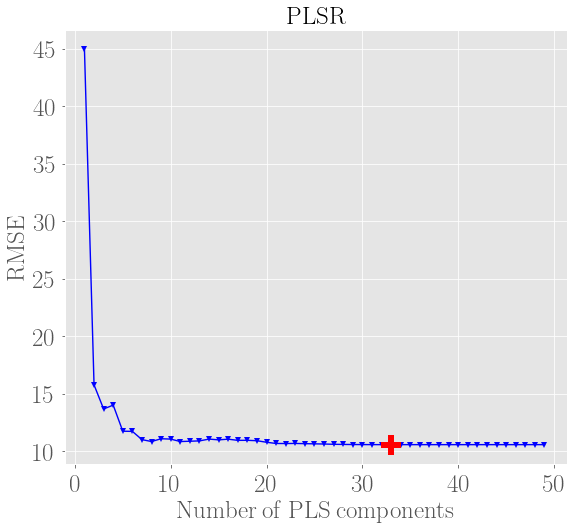


DNA:
R2 calib: 0.999
R2 CV: 0.899
RMSE calib: 0.559
RMSE CV: 5.355

Protein:
R2 calib: 1.000
R2 CV: 0.956
RMSE calib: 1.118
RMSE CV: 13.833

Lipid:
R2 calib: 0.989
R2 CV: 0.852
RMSE calib: 2.795
RMSE CV: 10.428


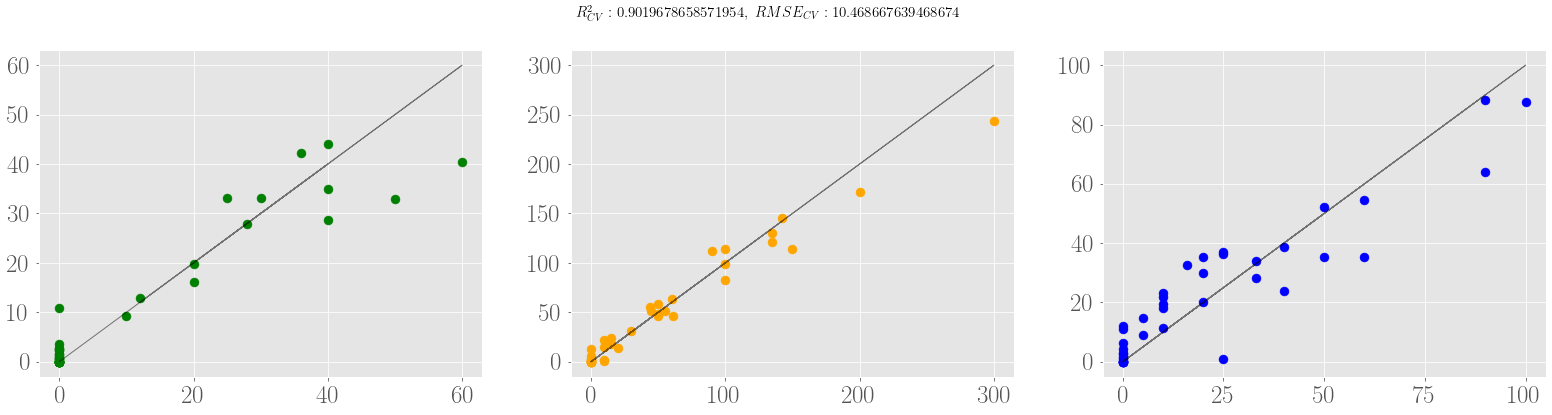

array([[ -6.43008208,  -9.74940903,   1.98595613],
       [ -1.91027239,   9.13964401,  -9.34897324],
       [ -5.29584221,   5.21465525,  -6.66274034],
       ...,
       [  0.62042668,  13.07729876,  17.46386076],
       [ -6.04982014,  19.65830118,   9.64302579],
       [-12.76178279,   9.62232783,  -8.82390133]])

<Figure size 432x288 with 0 Axes>

In [22]:
optimise_plsr_cv(X,y,50)

### Use CV-10 to select the best wavelengths to improve quantification prediction

In [12]:
    def pls_variable_selection(X, y, max_comp):
        
        # Define RMSE array to be populated
        RMSE = np.zeros((max_comp,X.shape[1]))
        # Loop over the number of PLS components
        for i in range(max_comp):
            
            # Regression with specified number of components, using full spectrum
            pls1 = PLSRegression(n_components=i+1,scale = False)
            pls1.fit(X, y)
            
            # Indices of sort spectra according to ascending absolute value of PLS coefficients
            sorted_ind = np.argsort(np.sum(abs(pls1.coef_),axis = 1))#ordered from lower to higher abs value (importance to the model)
            # Sort spectra accordingly 
            Xc = X[:,sorted_ind]
            # Discard one wavelength at a time of the sorted spectra,
            # regress, and calculate the RMSE cross-validation
            for j in range(Xc.shape[1]-(i+1)):
                pls2 = PLSRegression(n_components=i+1,scale=False)
                pls2.fit(Xc[:,j:], y)
                
                y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=10)
                y_cv[y_cv<0]=0
                RMSE[i,j] = np.sqrt(mean_squared_error(y, y_cv))
        
            comp = 100*(i+1)/(max_comp)
            stdout.write("\r%d%% completed" % comp)
            stdout.flush()
        stdout.write("\n")
        # # Calculate and print the position of minimum in RMSE
        RMSEminx,RMSEminy = np.where(RMSE==np.min(RMSE[np.nonzero(RMSE)]))
        print("Optimised number of PLS components: ", RMSEminx[0]+1)
        print("Wavelengths to be discarded ",RMSEminy[0])
        print('Optimised RMSEP ', RMSE[RMSEminx,RMSEminy][0])
        stdout.write("\n")
        plt.imshow(RMSE, interpolation=None)
        plt.show()
        # Calculate PLS with optimal components and export values   
        sorted_ind = np.argsort(np.sum(abs(pls1.coef_),axis = 1))
        Xc = X[:,sorted_ind]
        pls = PLSRegression(n_components=RMSEminx[0]+1,scale = False)
        pls.fit(Xc[:,RMSEminy[0]:], y) 
        return(RMSE,Xc[:,RMSEminy[0]:],RMSEminx[0]+1,RMSEminy[0], sorted_ind)

100% completed
Optimised number of PLS components:  15
Wavelengths to be discarded  574
Optimised RMSEP  5.812521037152685



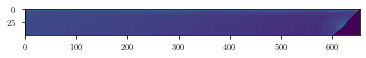

In [13]:
RMSE_matrix,opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X, y, 50)

100% completed
Suggested number of components without wavelength selection:  32



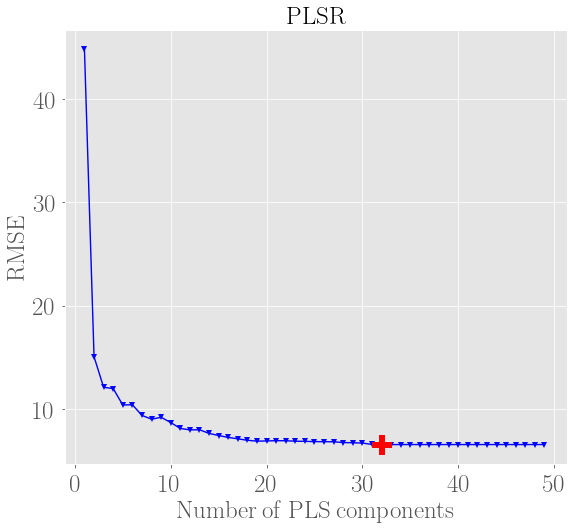


DNA:
R2 calib: 0.999
R2 CV: 0.964
RMSE calib: 0.561
RMSE CV: 3.199

Protein:
R2 calib: 1.000
R2 CV: 0.986
RMSE calib: 1.119
RMSE CV: 7.710

Lipid:
R2 calib: 0.989
R2 CV: 0.925
RMSE calib: 2.795
RMSE CV: 7.387


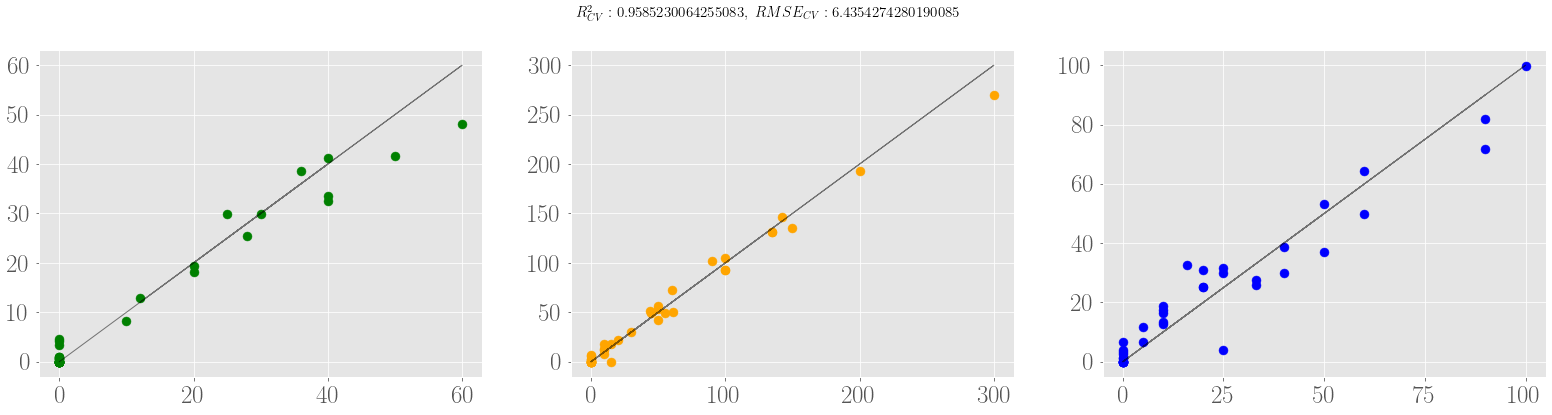

array([[-2.32945208e+01, -3.40663404e+00, -2.12103839e+02],
       [ 1.09339311e+01, -3.10218016e+01,  1.16889002e+01],
       [ 4.71916452e+01, -1.44792712e+01, -2.01550339e+01],
       [-6.64327485e+01,  2.98050260e+01, -5.13533117e+01],
       [ 3.55064785e+00, -1.20247017e+02,  2.00097089e+02],
       [ 5.67987021e+01, -8.08024336e+01, -4.73449104e+01],
       [ 6.17795524e+01, -9.21644073e+01, -8.04993670e+00],
       [-8.95936628e+01,  4.62364804e+01,  1.55053890e+02],
       [-5.78459506e+01,  1.06431317e+01,  8.81943990e+01],
       [ 8.00443237e+01,  1.44615386e+02,  1.12551143e+02],
       [-1.30791900e+02, -4.22152089e+01, -8.96223986e+01],
       [-6.83806161e+01, -5.92752256e+00,  6.75569023e+00],
       [ 4.46073916e+01,  2.89033007e+01, -1.37351867e+02],
       [ 1.19634124e+01, -7.52872062e+01,  1.02187206e+02],
       [-4.52029248e+01,  5.92448893e+01, -4.13749826e+01],
       [-3.58024955e+01,  1.36226358e+00, -6.27123787e+01],
       [ 1.30627751e+01, -7.47793372e+01

<Figure size 432x288 with 0 Axes>

In [14]:
optimise_plsr_cv(opt_Xc, y,50)

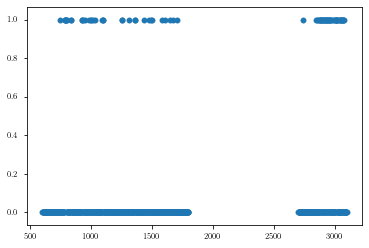

In [15]:
#discarded wavelengths 
wavelengths = data.columns.values[3:]
values = np.ones(len(wavelengths))
for i in range(wav):
    values[sorted_ind[i]] = 0
plt.scatter(wavelengths,values)


In [16]:
def wave_to_index(shift,minimum_wave,maximum_wave):
    #Enter wavenumber shift and the window limits in cm-1 and returns the index limits of that window
    if type(shift[0])!=int:
        shift = np.floor(shift)
        
    minimum = np.argmax(shift>minimum_wave-1)
    maximum = np.argmax(shift>maximum_wave-1)
    
    return (minimum,maximum)

In [17]:
wl = data.columns.values[3:].copy()
wl[wave_to_index(wl,1799,2701)[0]:wave_to_index(wl,1799,2701)[1]]=np.nan

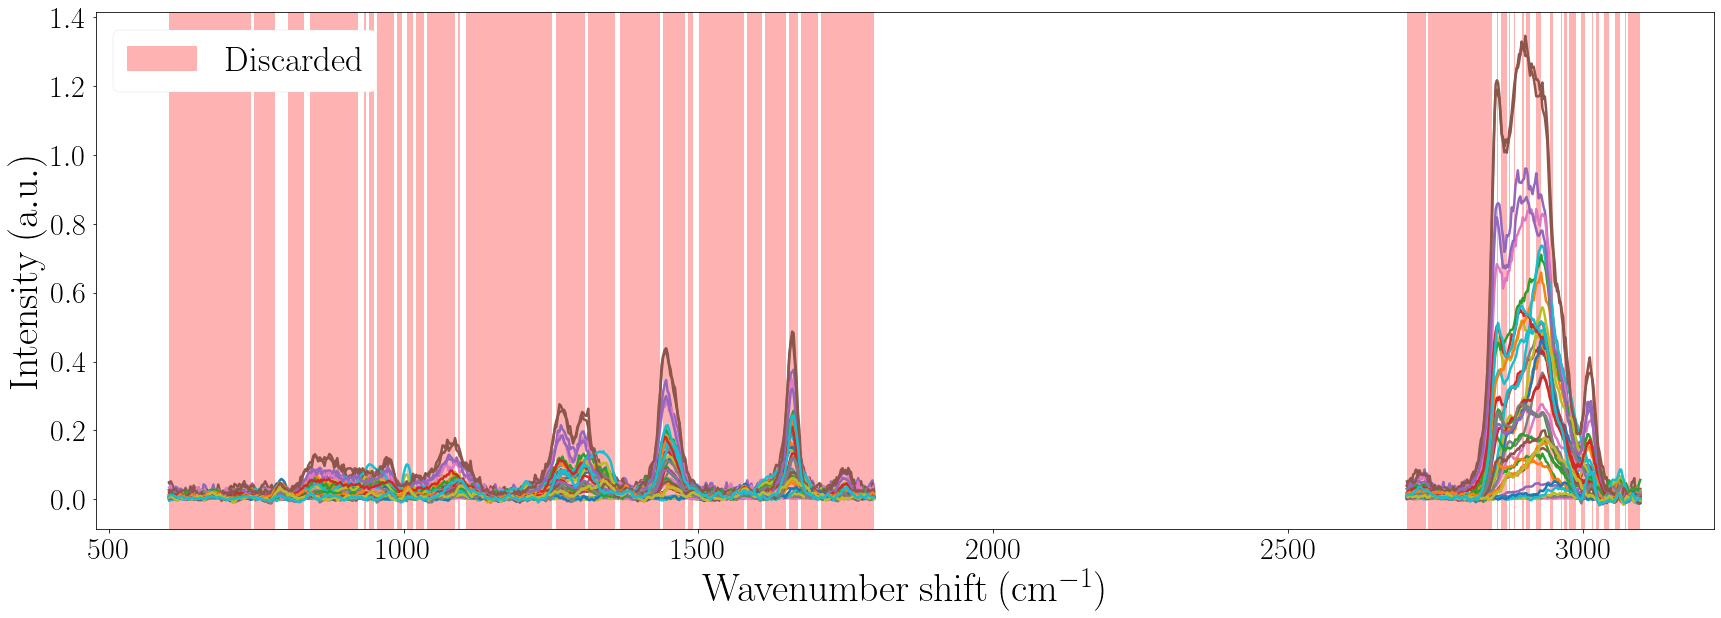

In [18]:
ix = np.in1d(wl.ravel(), wl[sorted_ind[:wav]])
import matplotlib.collections as collections
# Plot spectra with superimpose selected bands
fig, ax = plt.subplots(figsize=(29,9.5))

with plt.style.context(('ggplot')):
    ax.plot(wl, X.T,linewidth=2.5)
    plt.ylabel('$\mathrm{Intensity\: (a.u.)}$',fontsize = 40)
    plt.xlabel('$\mathrm{Wavenumber\: shift\: (cm^{-1})}$',fontsize = 40)
collection = collections.BrokenBarHCollection.span_where(
    wl, ymin=-1, ymax=1.45, where=ix == True, facecolor='red', alpha=0.3,label = '$\mathrm{Discarded}$')

ax.add_collection(collection)


plt.legend(loc='upper left',fontsize = 35,fancybox=True,framealpha=1)
plt.tick_params(labelsize=30)
plt.show()
fig.savefig('Wavelength selction PLSR',dpi=300,)

In [19]:
#wavelengths to be discarded
wav

574

In [20]:
# wavelengths to keep
sorted_ind[wav:]

array([612, 286, 401, 574, 409, 554, 183, 153, 642, 589, 601, 243, 558,
       622, 147, 611, 639, 537, 631, 185, 575, 532,  51, 285, 423, 603,
        72, 553, 577, 479, 118,  86, 628, 544, 573, 620, 244, 586, 547,
       265, 160, 141, 551, 566,  84,  66, 315, 339, 128, 585, 582, 332,
       534, 593, 337, 123, 630, 372,  67, 615, 180, 629, 609, 384, 120,
       608, 563,  70, 552, 548, 610,  68,  69, 565, 572, 146, 583, 637,
       638, 564], dtype=int64)

In [21]:
len(sorted_ind[wav:])

80

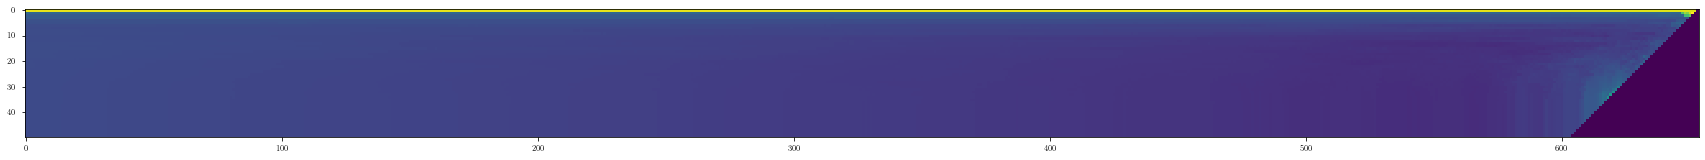

In [33]:
fig = plt.figure(figsize=(30,100))
plt.imshow(RMSE_matrix)